<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gnb.configuration()

Library,Version
OS,posix [linux]
Python,"3.10.4 (main, Mar 23 2022, 23:05:40) [GCC 11.2.0]"
IPython,8.3.0
Matplotlib,3.5.2
Numpy,1.21.6
pyDot,1.4.2
pyAgrum,1.1.0


# Credal Net from BN

In [3]:
bn=gum.fastBN("A->B[3]->C<-D<-A->E->F")
bn_min=gum.BayesNet(bn)
bn_max=gum.BayesNet(bn)
for n in bn.nodes():
  x=0.4*min(bn.cpt(n).min(),1-bn.cpt(n).max())
  bn_min.cpt(n).translate(-x)
  bn_max.cpt(n).translate(x)
    
cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()

gnb.flow.row(bn,bn.cpt("B"),cn,bn_min.cpt("B"),bn_max.cpt("B"),captions=["Bayes Net","CPT","Credal Net","CPTmin","CPTmax"])


#### We can use LBP on CN (L2U) only for binary credal networks (here B is not binary). We then propose the classical binarization (but warn the user that this leads to approximation in the inference)

In [4]:
cn2=gum.CredalNet(bn_min,bn_max)
cn2.intervalToCredal()
cn2.approximatedBinarization()
cn2.computeBinaryCPTMinMax()

gnb.flow.row(cn,cn2,captions=["Credal net","Binarized credal net"])

Here, $B$ becomes 
- $B$-b$i$ : the $i$-th bit of B
- instrumental $B$-v$k$ : the indicator variable for each modality $k$ of $B$

In [5]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie2_lbp=gum.CNLoopyPropagation(cn2)
ie2_mc=gum.CNMonteCarloSampling(cn2)

In [6]:
gnb.sideBySide(gnb.getInference(cn,engine=ie_mc),
               gnb.getInference(cn2,engine=ie2_mc),
               gnb.getInference(cn2,engine=ie2_lbp))

In [7]:
gnb.sideBySide(ie_mc.CN(),ie_mc.marginalMin("F"),ie_mc.marginalMax("F"),
               ie_mc.CN(),ie2_lbp.marginalMin("F"),ie2_lbp.marginalMax("F"),
              ncols=3)
print(cn)


A:Range([0,1])
<> : [[0.0837589 , 0.916241] , [0.195435 , 0.804565]]

B:Range([0,2])
<A:0> : [[0.60315 , 0.147547 , 0.249304] , [0.60315 , 0.19114 , 0.20571] , [0.646745 , 0.19114 , 0.162115] , [0.690339 , 0.147547 , 0.162115] , [0.646744 , 0.103952 , 0.249304] , [0.690339 , 0.103952 , 0.20571]]
<A:1> : [[0.272995 , 0.108987 , 0.618018] , [0.272995 , 0.152582 , 0.574423] , [0.316589 , 0.152582 , 0.530829] , [0.360184 , 0.108987 , 0.530829] , [0.31659 , 0.0653924 , 0.618018] , [0.360184 , 0.0653924 , 0.574424]]

C:Range([0,1])
<B:0|D:0> : [[0.500982 , 0.499018] , [0.513663 , 0.486337]]
<B:1|D:0> : [[0.418886 , 0.581114] , [0.431566 , 0.568434]]
<B:2|D:0> : [[0.114657 , 0.885343] , [0.127336 , 0.872664]]
<B:0|D:1> : [[0.977811 , 0.0221893] , [0.990491 , 0.00950872]]
<B:1|D:1> : [[0.143169 , 0.856831] , [0.155849 , 0.844151]]
<B:2|D:1> : [[0.62924 , 0.37076] , [0.641919 , 0.358081]]

D:Range([0,1])
<A:0> : [[0.593434 , 0.406566] , [0.783228 , 0.216772]]
<A:1> : [[0.142344 , 0.857656] , [

## Credal Net from bif files

In [8]:
cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()

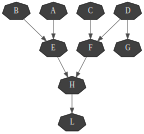

In [9]:
gnb.showCN(cn,"2")

In [10]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertEvidenceFile("res/cn/L2U.evi")

In [11]:
ie.setRepetitiveInd(False)
ie.setMaxTime(1)
ie.setMaxIter(1000)

ie.makeInference()

In [12]:
gnb.flow.row(cn,gnb.getInference(cn,targets={"A","H","L","D"},engine=ie,evs={"L":[0,1],"G":[1,0]}))

# Comparing inference in credal networks

In [13]:
import pyAgrum as gum

def showDiffInference(model,mc,lbp):
    for i in model.current_bn().nodes():
        a,b=mc.marginalMin(i)[:]
        c,d=mc.marginalMax(i)[:]
        
        e,f=lbp.marginalMin(i)[:]
        g,h=lbp.marginalMax(i)[:]
        
        plt.scatter([a,b,c,d],[e,f,g,h])
        

cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()

#### The two inference give quite the same result

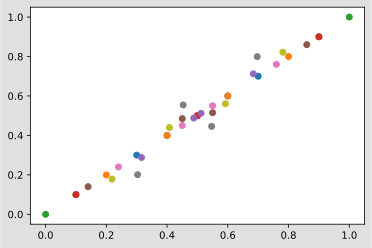

In [14]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.makeInference()

cn.computeBinaryCPTMinMax()
ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)

#### but not when evidence are inserted

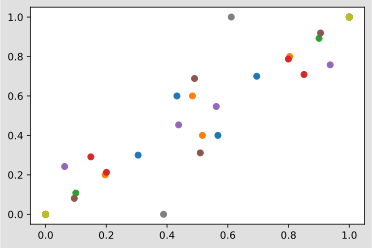

In [15]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.insertEvidenceFile("res/cn/L2U.evi")
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.insertEvidenceFile("res/cn/L2U.evi")
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)


## Dynamical Credal Net

In [16]:
cn=gum.CredalNet("res/cn/bn_c_8.bif","res/cn/den_c_8.bif")
cn.bnToCredal(0.8,False)

In [17]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile("res/cn/modalities.modal")

ie.setRepetitiveInd(True)
ie.setMaxTime(5)
ie.setMaxIter(1000)

ie.makeInference()

In [18]:
print(ie.dynamicExpMax("temp"))

(14.203404647522472, 11.669951317919612, 12.10019505553209, 11.99476087981647, 11.964516312727358, 11.941414476248845, 11.94838537443891, 11.945414782442136, 11.946445491630861)


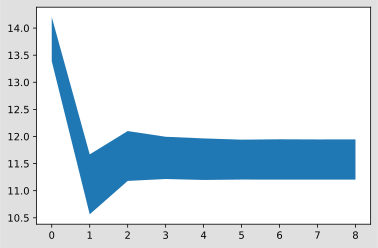

In [19]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

In [20]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile("res/cn/modalities.modal")

ie.setRepetitiveInd(False)
ie.setMaxTime(5)
ie.setMaxIter(1000)

ie.makeInference()
print(ie.messageApproximationScheme())

stopped with timeout=5


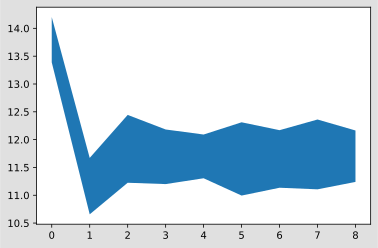

In [21]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

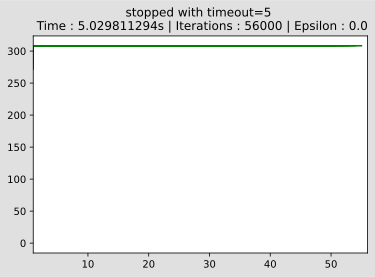

In [22]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile("res/cn/modalities.modal")

ie.setRepetitiveInd(False)
ie.setMaxTime(5)
ie.setMaxIter(5000)

gnb.animApproximationScheme(ie)
ie.makeInference()

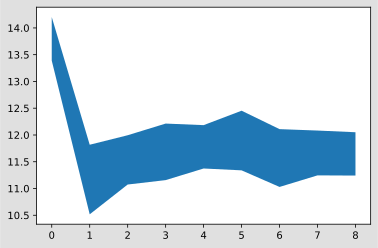

In [23]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"));